In [1]:
%matplotlib inline

In [192]:
from __future__ import print_function, division
import os
from tqdm import tqdm
import shutil
import numpy as np
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [193]:
TRAIN_DIR = './Train/'
TEST_DIR = './Test/'

TRAIN_FILE = './train_df.csv'
TEST_FILE = './test_df.csv'

##### Get class labels

In [301]:
classes = os.listdir(DATA_DIR)

len(classes)

14

In [302]:
class ShoeBrandDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, filepath, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.class_files = pd.read_csv(filepath)
        self.transform = transform
        self.lab2idx = {lab:idx for idx,lab in enumerate(os.listdir(root_dir))}
        self.idx2lab = {idx:lab for lab,idx in self.lab2idx.items()}

    def __len__(self):
        return len(self.class_files)

    def __getitem__(self, idx):
        label,filepath = self.class_files.iloc[idx]
        image = io.imread(filepath)
        sample = {'image': image, 'label': self.lab2idx[label]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

Let's instantiate this class and iterate through the data samples. We
will print the sizes of first 4 samples and show their landmarks.




In [303]:
shoe_dataset = ShoeBrandDataset(filepath=TRAIN_FILE,
                                root_dir=TRAIN_DIR)

6 (860, 986, 3)
128 (225, 225, 3)
25 (440, 440, 3)
331 (365, 440, 3)
339 (1440, 1080, 3)
659 (274, 300, 3)


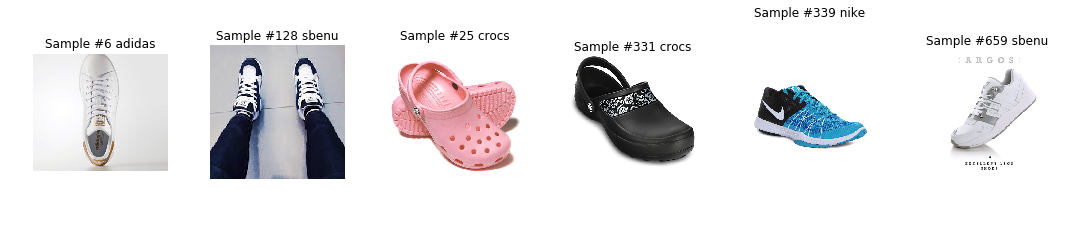

In [304]:
N_SHOW = 6

fig = plt.figure(figsize=(15,4))

for i in range(N_SHOW):
    index = np.random.randint(0, len(face_dataset), size=1)[0]
    sample = shoe_dataset[index]

    print(index, sample['image'].shape)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} {}'.format(index, shoe_dataset.idx2lab[sample['label']]))
    plt.imshow(sample['image'])
    ax.axis('off')
    
plt.show()

In [305]:
norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
crop = transforms.RandomCrop(224)
resize = transforms.Resize(256)

tsfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(30),
    resize,
    crop,
    transforms.ToTensor(),
    norm,
])

In [306]:
train_dataset = ShoeBrandDataset(filepath=TRAIN_FILE,
                                   root_dir=TRAIN_DIR,
                                   transform=tsfm,
                                   )

test_dataset = ShoeBrandDataset(filepath=TEST_FILE,
                               root_dir=TEST_DIR,
                               transform=tsfm,
                                )

In [307]:
from torch.autograd import Variable

In [308]:
BATCH_SIZE = 128

N_CLASSES = len(classes)

In [309]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,)

testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, )


In [317]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        _,c,w,h = x.size()
#         print(c,w,h)
        x = x.view(-1, c * w * h)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x


net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)

In [318]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [319]:
N_EPOCH = 30

In [320]:
history = {
    'epoch': [],
    'loss': [],
    'score': [],
}

for epoch in range(N_EPOCH):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs = Variable(data['image'].cuda())
        labels = Variable(data['label'].cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        _,predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        batch_loss = loss.item()
        running_loss += batch_loss / len(data)
        # get batch accuracy and save to epoch's total
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    
    history['epoch'].append(epoch)
    history['loss'].append(running_loss)
    history['score'].append(correct / total)
    
    print('[%d] Lloss %.4f, Score is %.4f' % (epoch, running_loss, correct/total))

[0], loss 14.5108, metric is 0.0775
[1], loss 14.3727, metric is 0.1376
[2], loss 14.1773, metric is 0.1694
[3], loss 14.0708, metric is 0.1875
[4], loss 14.0365, metric is 0.1832
[5], loss 13.9982, metric is 0.2028
[6], loss 13.9650, metric is 0.1977
[7], loss 13.9653, metric is 0.2165
[8], loss 13.9651, metric is 0.2028
[9], loss 13.8735, metric is 0.2187
[10], loss 13.8020, metric is 0.2317
[11], loss 13.8665, metric is 0.2201
[12], loss 13.8385, metric is 0.2238
[13], loss 13.6975, metric is 0.2505
[14], loss 13.7371, metric is 0.2498
[15], loss 13.6649, metric is 0.2621
[16], loss 13.6114, metric is 0.2744
[17], loss 13.5310, metric is 0.2925
[18], loss 13.6634, metric is 0.2585
[19], loss 13.5346, metric is 0.2896
[20], loss 13.4979, metric is 0.2969
[21], loss 13.4281, metric is 0.3106
[22], loss 13.6560, metric is 0.2636
[23], loss 13.6427, metric is 0.2679
[24], loss 13.5438, metric is 0.2940
[25], loss 13.5185, metric is 0.2875
[26], loss 13.5105, metric is 0.2940
[27], loss 

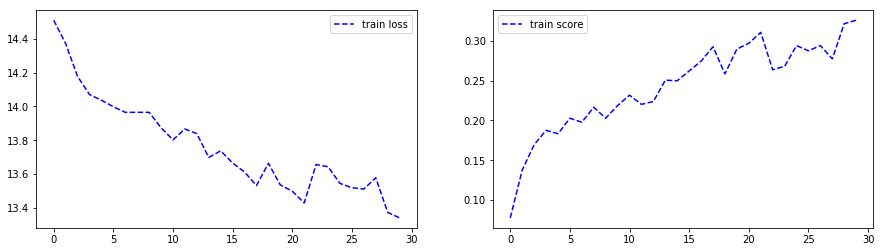

In [321]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(history['epoch'], history['loss'], 'b--', label='train loss')
plt.legend()
plt.subplot(122)
plt.plot(history['epoch'], history['score'], 'b--', label='train score')
plt.legend()
plt.show()

In [322]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs = Variable(data['image'].cuda())
        labels = Variable(data['label'].cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (
    total, 100 * correct / total))

Accuracy of the network on the 418 test images: 30 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

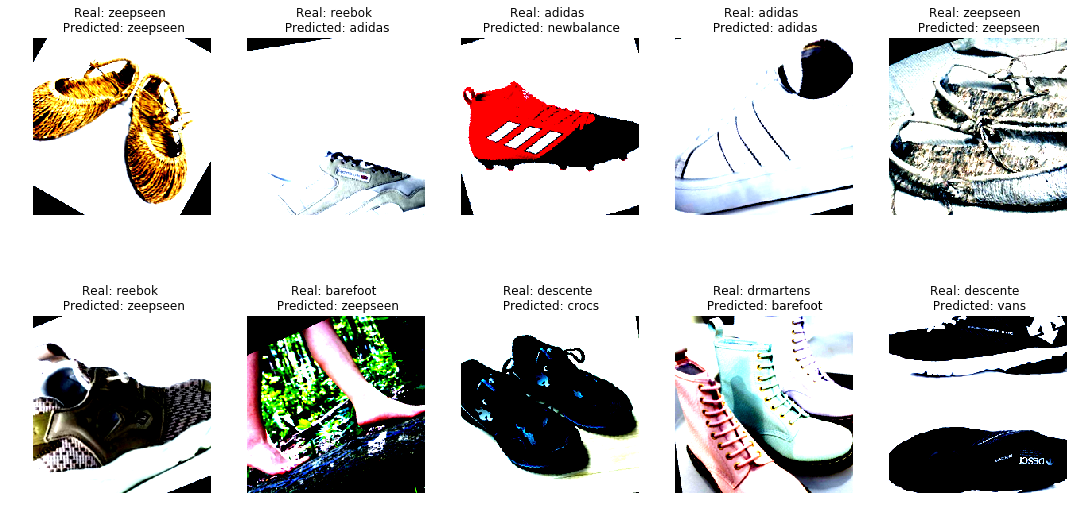

In [323]:
N_SHOW = 10

plt.figure(figsize=(15,8))
for i in range(N_SHOW):
    plt.subplot(2,5,i+1)
    img = np.moveaxis(np.array(inputs[i]), 0, 2) #reshape(224,224,3)
    plt.imshow(img)
    ttl = ['Real:', classes[labels[i]], '\n', 'Predicted:', classes[predicted[i].item()]]
    plt.title(" ".join(ttl))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [324]:
class_correct = list(0. for i in range(N_CLASSES))
class_total = list(0. for i in range(N_CLASSES))
with torch.no_grad():
    for data in testloader:
        inputs = Variable(data['image'].cuda())
        labels = Variable(data['label'].cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in labels:
#             label = labels[i]
            class_correct[i] += c[i].item()
            class_total[i] += 1


for i in range(N_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of lecoq : 33 %
Accuracy of crocs :  0 %
Accuracy of sbenu : 73 %
Accuracy of descente : 63 %
Accuracy of zeepseen : 10 %
Accuracy of converse :  0 %
Accuracy of barefoot : 23 %
Accuracy of newbalance :  0 %
Accuracy of adidas : 17 %
Accuracy of  puma : 40 %
Accuracy of  nike : 86 %
Accuracy of drmartens :  3 %
Accuracy of reebok : 70 %
Accuracy of  vans : 56 %


In [325]:
!python3 /data/home/akbds/.local/lib/python3.5/site-packages/telegram_send.py 'Done training the model'